# Unit Test Notebook for Gripper class functions

In [2]:
import importlib
importlib.reload(g)

<module 'magpie.gripper' from '/home/will/MAGPIE/magpie/prompt_planner/../../magpie/gripper.py'>

In [57]:
import sys
sys.path.append('../../')
import magpie.gripper as g
from magpie.gripper import Gripper
import time
servoport = '/dev/ttyACM0'
G = Gripper(servoport=servoport)

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 


In [9]:
G.close_gripper()

Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 


In [392]:
G.set_force(2.0)
G.set_goal_aperture(38, record_load=False)

Position of dxl ID: 1 set to 488 
Position of dxl ID: 2 set to 551 


In [11]:
G.aperture_to_z(70)

99.94899948270205

In [1010]:
G.reset_packet_overload()

Torque enable dxl ID: 1 set to 1 
Torque enable dxl ID: 2 set to 1 


In [60]:
left = []
right = []
while True:
    avg_l = []
    avg_r = []
    for i in range(10):
        force = G.get_force(finger='both')
        avg_l.append(force[0])
        avg_r.append(force[1])
        time.sleep(G.latency)
    al = sum(avg_l)/len(avg_l)
    ar = sum(avg_r)/len(avg_r)
    left.append(al)
    right.append(ar)
    print(f"L: {al:.3f} N, R: {ar:.3f} N")

L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.226 N, R: 0.157 N
L: 0.252 N, R: 0.157 N
L: 0.278 N, R: 0.157 N
L: 0.278 N, R: 0.157 N
L: 0.278 N, R: 0.157 N
L: 0.278 N, R: 0.157 N
L: 0.278 N, R: 0.157 N
L: 0.278 N, R: 0.157 N
L: 0.278 N, R: 0.157 N
L: 0.278 N, R: 0.157 N
L: 0.222 N, R: 0.157 N
L: 0.207 N, R: 0.157 N
L: 0.207 N,

KeyboardInterrupt: 

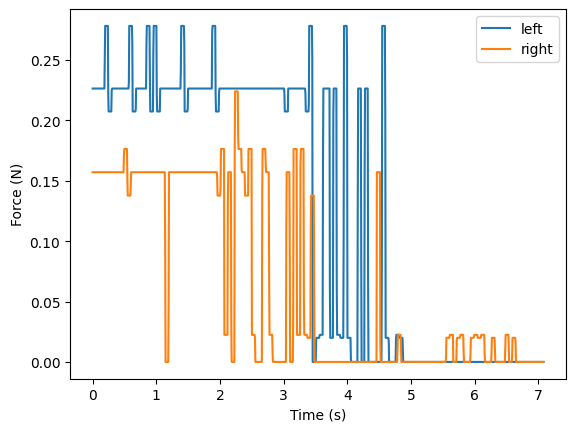

In [61]:
# plot left, right forces over time
# each entry in left, right is the average of 10 force readings
# which each take 10*G.latency seconds, or 6ms
# arrange x-axis as ticks of 60ms
import matplotlib.pyplot as plt
x = [i*0.006 for i in range(len(left))]
l_data = [x, left]
r_data = [x, right]
plt.plot(*l_data, label='left')
plt.plot(*r_data, label='right')
plt.ylabel('Force (N)')
plt.legend()
plt.xlabel('Time (s)')
plt.show()


In [58]:
G.reset_parameters()

Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [59]:
# grasp
import numpy as np

start = time.time()
# Setting the goal aperture slightly wider initially to ensure the delicate paper airplane isn't damaged on approach
goal_aperture = 50
# move quick
load_data = G.set_goal_aperture(goal_aperture+3, finger='both', record_load=False)
# Initial force determined by object weight and friction coefficient
initial_force = 0.25 # Calculated from (5.0 grams * 9.81 m/s^2) / 0.5 friction coefficient, converted to Newtons
# Additional closure amount and force increase if the gripper slips
additional_closure = 1.0
additional_force = 0.1
complete_grasp = True
# Ensuring there's a gentle and precise approach to hold the paper airplane without damage
# Setting the compliance slightly more flexible due to the high compliance nature of the task
G.set_compliance(0, 1, finger='both')
# Setting the initial force as it's vital in a grasp of a low-weight and highly compliant object like a paper airplane
G.set_force(initial_force, 'both')

# Move to the initial goal aperture to attempt the grasp
load_data = G.set_goal_aperture(goal_aperture, finger='both', record_load=True)
# Check the current aperture and adjust the goal aperture if necessary for a delicate grasp
curr_aperture = G.get_aperture(finger='both')
# Initializing the applied_force variable with the initial_force value
applied_force = initial_force
prev_aperture = curr_aperture
k_avg = []
# Checking for slip at the initial attempt, indicating whether the grip is firm or needs adjustment
slippage, avg_force, max_force = G.check_slip(load_data, initial_force, 'both')
# If there's slippage, the gripper needs more force and possibly a tighter grasp
while slippage:
    # goal_aperture = curr_aperture - additional_closure
    goal_aperture -= additional_closure
    if np.mean(avg_force) > 0.10: # low-pass filter force readings so we don't increase force when there is no contact
        applied_force += additional_force
    G.set_force(applied_force, 'both')
    print(f"Previous aperture: {curr_aperture} mm, Goal Aperture: {goal_aperture} mm, Applied Force: {applied_force} N.")
  
    load_data = G.set_goal_aperture(goal_aperture, finger='both', record_load=True)
    # Report data after each adjustment
    curr_aperture = G.get_aperture(finger='both')
    print(f"Current aperture: {curr_aperture} mm")
    # It's necessary to check slippage again after readjusting the force and aperture
    slippage, avg_force, max_force = G.check_slip(load_data, initial_force, 'both')
    distance = abs(curr_aperture - prev_aperture)
    k_avg.append(np.mean(avg_force) * distance * 1000.0)
    prev_aperture = curr_aperture
    
time.sleep(G.delay * 5)
# Confirming the final grasp settings

if complete_grasp:
    curr_aperture = G.get_aperture(finger='both')
    G.set_goal_aperture(curr_aperture - additional_closure, finger='both', record_load=False)
else:
    G.open_gripper()
# G.set_goal_aperture(curr_aperture , finger='both', record_load=False)
end = time.time()
print(f"Final aperture: {curr_aperture} mm, Controller Goal Aperture: {goal_aperture} mm, Applied Force: {applied_force} N.")
print(f"Spring Constants: {k_avg} N/m")

Position of dxl ID: 1 set to 455 
Position of dxl ID: 2 set to 584 
Position of dxl ID: 1 set to 453 
Position of dxl ID: 2 set to 586 
Position of dxl ID: 1 set to 454 
Position of dxl ID: 2 set to 585 
Position of dxl ID: 1 set to 455 
Position of dxl ID: 2 set to 584 
Position of dxl ID: 1 set to 456 
Position of dxl ID: 2 set to 583 
Position of dxl ID: 1 set to 457 
Position of dxl ID: 2 set to 582 
Position of dxl ID: 1 set to 458 
Position of dxl ID: 2 set to 581 
Position of dxl ID: 1 set to 459 
Position of dxl ID: 2 set to 580 
Position of dxl ID: 1 set to 460 
Position of dxl ID: 2 set to 579 
stop_load: 71.4285714285713, stop_force: 0.175 N
force_r: 0.1763712 N, force_l: 0.1739713 N
avg_r: 0.17427136406250002 N, avg_l: 0.1634552765625 N
Previous aperture: 53.89546075454233 mm, Goal Aperture: 49.0 mm, Applied Force: 0.44999999999999996 N.
Position of dxl ID: 1 set to 451 
Position of dxl ID: 2 set to 586 
Position of dxl ID: 1 set to 452 
Position of dxl ID: 2 set to 585 
Po

In [31]:
print(f"Final x: {curr_aperture} mm, Goal x: {goal_aperture} mm, Applied Force: {applied_force} N.")
print(f"Time to grasp: {end - start} seconds")
print(f"Spring Constants: {k_avg} N/m")

Final x: 56.08163370356077 mm, Goal x: 45.0 mm, Applied Force: 6.2 N.
Time to grasp: 3.2917325496673584 seconds
Spring Constants: [651.5895167644912, 1012.6169488087886, 987.7635712362867, 1524.3126209375544] N/m


In [433]:
# from magpie.gripper import Gripper  # import the gripper class
# import numpy as np  # import numpy for later data manipulation

# new_task = True # Whether or not the task is new
# # Reset parameters to default since this is a new, delicate grasp to avoid crushing the raspberry.
# if new_task:
#     G.reset_parameters()

# # The goal is to be gentle and precise, given the high compliance and low weight of the object.
# goal_aperture = 60.0 # The initial goal aperture is set to 30mm to softly enclose the raspberry without squishing it.
# complete_grasp = True # Whether or not the grasp is complete
# initial_force = 2.0  # Initial force. The default value of object weight / friction coefficient.
# additional_closure = 2.0 # Amount to decrease the aperture by if slipping occurs.
# additional_force_increase = 0.2 # Amount to increase the force by if slipping occurs. Default value is (object spring constant * additional_closure) / damping constant.

# # Move quickly (without recording load) to a safe goal aperture
# G.set_goal_aperture(goal_aperture + 3, finger='both', record_load=False)

# G.set_compliance(1, 3, finger='both')  # A small margin with a middle-ground flexibility is chosen for compliance.
# # Set the gripper to have a soft touch by setting the initial gripping force very low.
# # Additionally, enable compliance to make the gripper adaptable to minor size variations of the raspberry.
# G.set_force(initial_force, 'both')  # Apply the initial gentle force to both fingers.
# # The anticipated action below will attempt to grasp the raspberry at the set aperture and force.
# # There's an expectancy to achieve a gentle, safe grasp around the raspberry without exerting too much pressure.
# load_data = G.set_goal_aperture(goal_aperture, finger='both', record_load=True)

# # Check the current aperture after setting the goal to ensure proper grip without damaging the raspberry.
# curr_aperture = G.get_aperture(finger='both')
# applied_force = initial_force
# prev_aperture = curr_aperture
# slippage = G.check_slip(load_data, initial_force, 'both')
# print(f"Initial aperture: {curr_aperture} mm")
# while slippage:
#     # If a slip is detected, the aperture decreases slightly to attempt a firmer grip.
#     goal_aperture = curr_aperture - additional_closure
#     # Concomitantly, the grip force is moderately increased to try securing the raspberry better without harm.
#     applied_force += additional_force_increase
#     # Apply the adjusted force setting to both fingers.
#     G.set_force(applied_force, 'both')
#     time.sleep(G.delay)
#     # Re-attempt the grasp with modified settings aiming for a successful, delicate grip.
#     load_data = G.set_goal_aperture(goal_aperture, finger='both', record_load=True)
    
#     # Re-evaluate the current aperture to confirm the attainment of a more stable grip without slippage.
#     prev_aperture = curr_aperture
#     curr_aperture = G.get_aperture(finger='both')
#     print(f"prev_aperture: {prev_aperture} mm, Current aperture: {curr_aperture} mm, distance: {prev_aperture - curr_aperture} mm")
#     print(f"Current aperture: {curr_aperture} mm, Goal Aperture: {goal_aperture} mm, Applied Force: {applied_force} N.")
#     time.sleep(G.delay * 30)

#     # Check for slippage again to determine if the grasp is secure.
#     slippage,  = G.check_slip(load_data, initial_force, 'both')

# if complete_grasp:
#     curr_aperture = G.get_aperture(finger='both')
#     print(f"Final aperture: {curr_aperture} mm, Controller Goal Aperture: {goal_aperture} mm, Applied Force: {applied_force} N.")
#     G.set_goal_aperture(curr_aperture - 2, finger='both', record_load=False)
# else:
#     G.open_gripper()


Position of dxl ID: 1 set to 415 
Position of dxl ID: 2 set to 624 
Position of dxl ID: 1 set to 412 
Position of dxl ID: 2 set to 624 
Position of dxl ID: 1 set to 413 
Position of dxl ID: 2 set to 623 
Position of dxl ID: 1 set to 414 
Position of dxl ID: 2 set to 622 
Position of dxl ID: 1 set to 415 
Position of dxl ID: 2 set to 621 
Position of dxl ID: 1 set to 416 
Position of dxl ID: 2 set to 620 
Position of dxl ID: 1 set to 417 
Position of dxl ID: 2 set to 619 
Position of dxl ID: 1 set to 418 
Position of dxl ID: 2 set to 618 
Position of dxl ID: 1 set to 419 
Position of dxl ID: 2 set to 617 
Position of dxl ID: 1 set to 420 
Position of dxl ID: 2 set to 616 
Position of dxl ID: 1 set to 421 
Position of dxl ID: 2 set to 615 
Position of dxl ID: 1 set to 422 
Position of dxl ID: 2 set to 614 
Position of dxl ID: 1 set to 423 
Position of dxl ID: 2 set to 613 
Position of dxl ID: 1 set to 424 
Position of dxl ID: 2 set to 612 
Position of dxl ID: 1 set to 425 
Position of dx

In [19]:
G.set_force(12.0)

In [20]:
G.get_torque(finger='both')

[550, 550]

In [189]:
G.open_gripper()

[RxPacketError] Overload error!
[RxPacketError] Overload error!
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [178]:
G.reset_parameters()

Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [86]:
G.get_aperture(finger='both')

79.40480967920502

In [90]:
G.set_torque(60, finger='both')
G.set_speed(60, finger='both')

Moving speed of dxl ID: 1 set to 60 
Moving speed of dxl ID: 2 set to 60 


In [92]:
desired_dist = 85
G.set_goal_aperture(desired_dist, finger='both', debug=True) #25mm aperture between fingers

position: 375
Position of dxl ID: 1 set to 375 
position: 664
Position of dxl ID: 2 set to 664 


In [70]:
pld = G.set_goal_aperture(5, finger='both', debug=False, record_load=True) #25mm aperture between fingers

Position of dxl ID: 1 set to 374 
Position of dxl ID: 2 set to 665 
Position of dxl ID: 1 set to 375 
Position of dxl ID: 2 set to 664 
Position of dxl ID: 1 set to 376 
Position of dxl ID: 2 set to 663 
Position of dxl ID: 1 set to 377 
Position of dxl ID: 2 set to 662 
Position of dxl ID: 1 set to 378 
Position of dxl ID: 2 set to 661 
Position of dxl ID: 1 set to 379 
Position of dxl ID: 2 set to 660 
Position of dxl ID: 1 set to 380 
Position of dxl ID: 2 set to 659 
Position of dxl ID: 1 set to 381 
Position of dxl ID: 2 set to 658 
Position of dxl ID: 1 set to 382 
Position of dxl ID: 2 set to 657 
Position of dxl ID: 1 set to 383 
Position of dxl ID: 2 set to 656 
Position of dxl ID: 1 set to 384 
Position of dxl ID: 2 set to 655 
Position of dxl ID: 1 set to 385 
Position of dxl ID: 2 set to 654 
Position of dxl ID: 1 set to 386 
Position of dxl ID: 2 set to 653 
Position of dxl ID: 1 set to 387 
Position of dxl ID: 2 set to 652 
Position of dxl ID: 1 set to 388 
Position of dx

In [86]:
G.N_to_load(0.15)

61.04336176433776

In [166]:
# validate z-offset (10mm aperture on either finger should be 20mm)
desired_dist = 55
zoff = G.aperture_to_z(desired_dist, finger='both', debug=True)
print(f"z-offset: {zoff} mm")

theta: 17.885218585596558, l2: 42.82531494338366, l1: 81.32, y_fingertip: 103.14531494338365
z-offset: 103.14531494338365 mm


In [98]:
G.get_aperture(finger='both')

105.48645436150926

In [119]:
G.Finger1.get_present_position()

293

In [118]:
G.get_aperture(finger='left')

53.9484487042254

In [122]:
G.close_until_contact_force(30, 3.0, finger='left', debug=True)

position: 438
Position of dxl ID: 1 set to 295 
Position of dxl ID: 1 set to 294 
Position of dxl ID: 1 set to 293 
Position of dxl ID: 1 set to 290 
Position of dxl ID: 1 set to 289 
Position of dxl ID: 1 set to 288 
Position of dxl ID: 1 set to 287 
Position of dxl ID: 1 set to 286 
Position of dxl ID: 1 set to 285 
Position of dxl ID: 1 set to 284 
Position of dxl ID: 1 set to 283 
Position of dxl ID: 1 set to 282 
Position of dxl ID: 1 set to 281 
Position of dxl ID: 1 set to 280 
Position of dxl ID: 1 set to 279 
Position of dxl ID: 1 set to 278 
Position of dxl ID: 1 set to 277 
Position of dxl ID: 1 set to 275 
Position of dxl ID: 1 set to 274 
Position of dxl ID: 1 set to 273 
Position of dxl ID: 1 set to 272 
left finger reached stop force: 3.2689470400000005 at distance: 54.252107976649704
left finger reached stop load: 192 at position: 292
Position of dxl ID: 1 set to 292 


In [273]:
G.get_load(finger='left')

0

In [5]:
G.set_compliance(2, 7, finger='left', debug=True)
G.set_compliance(2, 7, finger='right', debug=True)

margin_ax12: 9
flexibility_ax12: 128
margin_ax12: 9
flexibility_ax12: 128


In [238]:
[G.get_aperture(finger='left'), G.get_aperture(finger='right')]

[53.20311759145189, 52.04459477753785]

In [51]:
import numpy as np
finger = 'right'
finger_ax12 = G.Finger1 if finger == 'left' else G.Finger2
latency = 0.0006
delay = 0.0055
stop_force = 0.25
stop_load = G.N_to_load(stop_force)
stop_aperture = 30 # mm
curr_pos = G.get_aperture(finger=finger)
curr_pos = finger_ax12.get_present_position()
stop_ax12 = G.theta_to_position(G.aperture_to_theta(stop_aperture), finger=finger, debug=True)
delta = stop_ax12 - int(curr_pos)
sign = np.sign(delta)

stop_ax12, stop_load

position: 601


(601, 100.18198855127346)

In [39]:
G.set_torque(120, finger='both')

In [42]:
finger_ax12.set_goal_position(728)

Position of dxl ID: 2 set to 728 


In [54]:
curr_pos = finger_ax12.get_present_position()
range(curr_pos, stop_ax12)

range(728, 601)

In [63]:
time.sleep(latency)
for next_pos in range(curr_pos, stop_ax12, sign*1):
    finger_ax12.set_goal_position(next_pos)
    time.sleep(delay)
    time.sleep(delay)
    curr_pos = finger_ax12.get_present_position()
    curr_load = finger_ax12.get_load()
    if curr_load > 1023:
        curr_load = curr_load - 1023
    print(f'curr_load: {curr_load}, curr_pos: {curr_pos}')
    time.sleep(delay)
    time.sleep(latency)
    if curr_load > stop_load:
        force = G.load_to_N(curr_load)
        distance = G.get_aperture(finger=finger)
        print(f'{finger} finger reached stop force: {force} at distance: {distance}')
        print(f'{finger} finger reached stop load: {curr_load} at position: {curr_pos}')
        # todo: set goal_distance_fx class variable, but not really necessary
        finger_ax12.set_goal_position(curr_pos)
        break

Position of dxl ID: 2 set to 642 
curr_load: 0, curr_pos: 728
Position of dxl ID: 2 set to 641 
curr_load: 0, curr_pos: 728
Position of dxl ID: 2 set to 640 
curr_load: 0, curr_pos: 726
Position of dxl ID: 2 set to 639 
curr_load: 0, curr_pos: 725
Position of dxl ID: 2 set to 638 
curr_load: 88, curr_pos: 723
Position of dxl ID: 2 set to 637 
curr_load: 88, curr_pos: 722
Position of dxl ID: 2 set to 636 
curr_load: 88, curr_pos: 719
Position of dxl ID: 2 set to 635 
curr_load: 88, curr_pos: 717
Position of dxl ID: 2 set to 634 
curr_load: 88, curr_pos: 715
Position of dxl ID: 2 set to 633 
curr_load: 88, curr_pos: 712
Position of dxl ID: 2 set to 632 
curr_load: 88, curr_pos: 710
Position of dxl ID: 2 set to 631 
curr_load: 16, curr_pos: 708
Position of dxl ID: 2 set to 630 
curr_load: 16, curr_pos: 706
Position of dxl ID: 2 set to 629 
curr_load: 16, curr_pos: 704
Position of dxl ID: 2 set to 628 
curr_load: 16, curr_pos: 700
Position of dxl ID: 2 set to 627 
curr_load: 16, curr_pos: 

In [62]:
finger_ax12.set_goal_position(728)

Position of dxl ID: 2 set to 728 


In [46]:
G.get_load(finger='right')

0

In [47]:
G.open_gripper()

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


# Testing L2G Generation

In [170]:
G.reset_packet_overload()

Torque enable dxl ID: 1 set to 1 
Torque enable dxl ID: 2 set to 1 


In [33]:
G.aperture_to_z(80, finger='both', debug=True)

theta: 35.79514090937181, l2: 36.50010410944057, l1: 81.32, y_fingertip: 96.82010410944056


96.82010410944056

In [18]:
G.open_gripper()

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [17]:
G.close_gripper()

Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 


In [34]:
# time.sleep(5.0)
G.set_force(2.0, finger='both')
G.set_goal_aperture(80, finger='both', debug=True)
# G.close_gripper()

position: 389
Position of dxl ID: 1 set to 389 
position: 650
Position of dxl ID: 2 set to 650 


In [63]:
G.reset_parameters()

Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [62]:
# plastic bag
# Reset parameters for a new grasp task, ensuring all previous settings are cleared.
# G.reset_parameters()
# time.sleep(5.0)

# [Grasping a delicate object like a paper airplane requires precision without exerting excessive force.]
# Setting compliance parameters to allow for a gentle grip, reducing risk of damage to the high compliant, low weight object.
G.set_compliance(margin=4, flexibility=3, finger='both')
time.sleep(0.01)
# Setting a conservative initial force to avoid crushing the paper airplane, ensuring a gentle grip.
G.set_force(4.0, 'both')
time.sleep(0.1)

# Getting the current goal aperture to adjust for the size of the object.
# goal_aperture = G.get_goal_aperture(finger='both')
goal_aperture = 75

# Adjusting the goal aperture slightly smaller than the initial to ensure contact with the object, considering its compliance and low weight.
G.set_goal_aperture(goal_aperture, finger='both', record_load=False)
time.sleep(3.0)

# # [To confirm the grasp without causing damage, a slight increase in force is needed after initial contact.]
# # Increasing the force slightly by 0.5N to ensure a secure grip on the paper airplane without applying too much pressure.
G.set_force(5.5, 'both')
time.sleep(0.10)

# # Checking the current aperture to ensure the fingers have moved as intended.
curr_aperture = G.get_aperture(finger='both')
print(f'Current aperture: {curr_aperture} mm')
time.sleep(0.01)

# # If the current aperture is not as expected, adjust the goal aperture slightly to improve the grip.
# # Here we assume there might be a need to adjust based on the object's compliance; adjust based on your guess or requirement.
additional_closure = 25
G.set_goal_aperture(curr_aperture - additional_closure, finger='both', record_load=False)
time.sleep(3.5)


Position of dxl ID: 1 set to 402 
Position of dxl ID: 2 set to 637 
Current aperture: 77.62770118111555 mm
Position of dxl ID: 1 set to 455 
Position of dxl ID: 2 set to 584 


In [46]:
G.get_aperture(finger='both')

75.5710350287771

In [31]:
# clementine, sleeps are manual
# Reset parameters for a new grasp task, ensuring all previous settings are cleared.
# G.reset_parameters()
# time.sleep(5.0)

# [Grasping a delicate object like a paper airplane requires precision without exerting excessive force.]
# Setting compliance parameters to allow for a gentle grip, reducing risk of damage to the high compliant, low weight object.
G.set_compliance(margin=5, flexibility=4, finger='both')
time.sleep(0.01)
# Setting a conservative initial force to avoid crushing the paper airplane, ensuring a gentle grip.
G.set_force(1.0, 'both')
time.sleep(0.1)

# Getting the current goal aperture to adjust for the size of the object.
# goal_aperture = G.get_goal_aperture(finger='both')
goal_aperture = 49

# Adjusting the goal aperture slightly smaller than the initial to ensure contact with the object, considering its compliance and low weight.
G.set_goal_aperture(goal_aperture, finger='both', record_load=False)
time.sleep(4.0)

# # [To confirm the grasp without causing damage, a slight increase in force is needed after initial contact.]
# # Increasing the force slightly by 0.5N to ensure a secure grip on the paper airplane without applying too much pressure.
G.set_force(1.5, 'both')
time.sleep(0.10)

# # Checking the current aperture to ensure the fingers have moved as intended.
curr_aperture = G.get_aperture(finger='both')
print(f'Current aperture: {curr_aperture} mm')
time.sleep(0.01)

# # If the current aperture is not as expected, adjust the goal aperture slightly to improve the grip.
# # Here we assume there might be a need to adjust based on the object's compliance; adjust based on your guess or requirement.
additional_closure = 7
G.set_goal_aperture(curr_aperture - additional_closure, finger='both', record_load=False)
time.sleep(2.5)


Position of dxl ID: 1 set to 464 
Position of dxl ID: 2 set to 575 
Current aperture: 54.275721515032856 mm
Position of dxl ID: 1 set to 467 
Position of dxl ID: 2 set to 572 


In [140]:
# paper plane, sleeps are manual
# Reset parameters for a new grasp task, ensuring all previous settings are cleared.
# G.reset_parameters()
time.sleep(5.0)

# [Grasping a delicate object like a paper airplane requires precision without exerting excessive force.]
# Setting compliance parameters to allow for a gentle grip, reducing risk of damage to the high compliant, low weight object.
G.set_compliance(margin=1, flexibility=5, finger='both')
time.sleep(0.01)
# Setting a conservative initial force to avoid crushing the paper airplane, ensuring a gentle grip.
G.set_force(0.15, 'both')
time.sleep(0.1)

# Getting the current goal aperture to adjust for the size of the object.
# goal_aperture = G.get_goal_aperture(finger='both')
goal_aperture = 18

# Adjusting the goal aperture slightly smaller than the initial to ensure contact with the object, considering its compliance and low weight.
G.set_goal_aperture(goal_aperture - 5, finger='both', record_load=False)
time.sleep(2.5)

# # [To confirm the grasp without causing damage, a slight increase in force is needed after initial contact.]
# # Increasing the force slightly by 0.5N to ensure a secure grip on the paper airplane without applying too much pressure.
G.set_force(0.65, 'both')
time.sleep(0.10)

# # Checking the current aperture to ensure the fingers have moved as intended.
curr_aperture = G.get_aperture(finger='both')
print(f'Current aperture: {curr_aperture} mm')
time.sleep(0.01)

# # If the current aperture is not as expected, adjust the goal aperture slightly to improve the grip.
# # Here we assume there might be a need to adjust based on the object's compliance; adjust based on your guess or requirement.
G.set_goal_aperture(curr_aperture - 2, finger='both', record_load=False)
time.sleep(2.5)


Position of dxl ID: 1 set to 542 
Position of dxl ID: 2 set to 497 
Current aperture: 17.705124633955062 mm
Position of dxl ID: 1 set to 536 
Position of dxl ID: 2 set to 503 


In [160]:
G.reset_parameters()
G.set_goal_aperture(75, finger='both', debug=True)


Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
position: 402
Position of dxl ID: 1 set to 402 
position: 637
Position of dxl ID: 2 set to 637 


In [168]:
# time.sleep(5.0)
G.set_force(8.0, finger='both')
G.set_goal_aperture(55, finger='both', debug=True)
G.close_gripper()


position: 450
Position of dxl ID: 1 set to 450 
position: 589
Position of dxl ID: 2 set to 589 
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 


In [167]:
# credit card

# Reset parameters for a new grasp task, ensuring all previous settings are cleared.
# G.reset_parameters()
# time.sleep(5.0)

# [Grasping a delicate object like a paper airplane requires precision without exerting excessive force.]
# Setting compliance parameters to allow for a gentle grip, reducing risk of damage to the high compliant, low weight object.
G.set_compliance(margin=0.5, flexibility=2, finger='both')
time.sleep(0.01)
# Setting a conservative initial force to avoid crushing the paper airplane, ensuring a gentle grip.
G.set_force(0.6, 'both')
time.sleep(0.1)

# Getting the current goal aperture to adjust for the size of the object.
# goal_aperture = G.get_goal_aperture(finger='both')
goal_aperture = 0

# Adjusting the goal aperture slightly smaller than the initial to ensure contact with the object, considering its compliance and low weight.
G.set_goal_aperture(goal_aperture - 5, finger='both', record_load=False)
time.sleep(2.5)

# # [To confirm the grasp without causing damage, a slight increase in force is needed after initial contact.]
# # Increasing the force slightly by 0.5N to ensure a secure grip on the paper airplane without applying too much pressure.
G.set_force(0.9, 'both')
time.sleep(0.10)

# # Checking the current aperture to ensure the fingers have moved as intended.
curr_aperture = G.get_aperture(finger='both')
print(f'Current aperture: {curr_aperture} mm')
time.sleep(0.01)

# # If the current aperture is not as expected, adjust the goal aperture slightly to improve the grip.
# # Here we assume there might be a need to adjust based on the object's compliance; adjust based on your guess or requirement.
G.set_goal_aperture(curr_aperture - 2, finger='both', record_load=False)
time.sleep(2.5)


Position of dxl ID: 1 set to 583 
Position of dxl ID: 2 set to 456 
Current aperture: 98.07154262472713 mm
Position of dxl ID: 1 set to 341 
Position of dxl ID: 2 set to 698 


# Testing Getters and Setters

## Getters

In [27]:
print(G.get_load(finger='both'))

[0, 0]


In [28]:
print(G.get_position(finger='both'))

[526, 511]


In [30]:
print(G.get_temp(finger='both'))

[37, 36]


In [33]:
print(G.get_aperture(finger='both'))

19.986677024361736


In [34]:
# compare with Dylan's code
print(G.get_distance(finger='both'))

24.138556173746146


## Setters

In [91]:
G.load_to_N(40)

0.09888000000000001

In [90]:
G.N_to_load(.1)

40.45832530419774

In [41]:
# 1 N
G.set_force(2.0, finger='both', debug=True)
time.sleep(0.005)
G.get_load(finger='both')

converted load: 0


[0, 0]

In [ ]:
# set distance to 20 mm 
G.set_goal_distance(20, debug=True)
time.sleep(0.5)
print(G.get_distance(finger='both'))
print(G.get_aperture(finger='both'))
print(G.get_position(finger='both'))

In [ ]:
# set compliance (in mm, slope[0-7])
G.set_compliance(5, 4, finger='both', debug=True)
time.sleep(0.005) 
print(G.get_compliance(finger='both'))


In [2]:
# https://platform.openai.com/docs/guides/vision
import openai
import base64
import requests
import os
from PIL import Image
from pillow_heif import register_heif_opener
import torch
from transformers.image_utils import ImageFeatureExtractionMixin

# import open3d as o3d
import numpy as np
# import pyrealsense2 as rs
import matplotlib.pyplot as plt
# import RealSense as real

# # Initialize RS435i connection
# rsc = real.RealSense()
# rsc.initConnection()


In [25]:
api_key = os.getenv("OPENAI_API_KEY")


In [31]:
# Path to your image
image_path = "data_snapshots/rgb_image_ur5.png"
image_path_labeled = 'data_snapshots/owlvit_inference.png'

# Getting the base64 string
base64_image = encode_image(image_path)
base64_image_labeled = encode_image(image_path_labeled)

api_key = os.getenv("OPENAI_API_KEY")

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

text1 = """
You are planning a grasp for a robotic manipulator in a grocery bin. 
You will validate whether the labeled objects are present in the bin and correct the list of labels if there are any incongruities.
For example if a the label in the image is "apple (3)" but the object is a "pear", you will correct the label to "pear (3)" in the format of the provided caption.
The number in the image label corresponds to the index of the object in the list of objects.
You are provided with a photo of the grocery bin, a photo of the indexed and labeled grocery bins, and a list of labels with matching indices.
In your response, first identify any errors in the labels or missing labels. Then, finish your response in the format of the provided caption, with corrections applied.
Make sure to mention the index of the fruit associated with the error.
"""

resp1 = """
I see: ["a photo of a lemon", "a photo of an apple", "a photo of a pear", "a photo of an onion", "a photo of a lime"]
Labels: ["lemon", "apple", "pear", "onion", "lime"]
"""

text2 = """
Please generate a list of labels for this new image of the grocery bin, in the same format.
Are there any new fruits or vegetables?
"""
question = """
No further information required.
Now I am looking at a painting of people looking at a shore.
"""

payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"{text1}"
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image_labeled}"
            }
          }]
      },
      # {
      #   "role": "assistant",
      #   "content": [
      #     {
      #       "type": "text",
      #       "text": f"{resp1}"
      #     }]
      # },
      # {
      #   "role": "user",
      #   "content": [
      #     {
      #       "type": "text",
      #       "text": f"{text2}"
      #     },
      #     {
      #       "type": "image_url",
      #       "image_url": {
      #         "url": f"data:image/jpeg;base64,{base64_image_avo}"
      #       }
      #     }]
      # }          
      ],
    "max_tokens": 1000
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json())

{'id': 'chatcmpl-8q2WxRjlJrltz2XHTlAbPBmXc1HHz', 'object': 'chat.completion', 'created': 1707413475, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 2058, 'completion_tokens': 169, 'total_tokens': 2227}, 'choices': [{'message': {'role': 'assistant', 'content': 'Based on the provided images, the following errors in the labels have been identified:\n\n1. The object labeled as "orange (4)" is actually a red apple.\n2. The item labeled as "orange (5)" is a red apple.\n3. The item labeled as "orange (9)" is a green pear.\n\nGiven this information, the corrected list of labels with matching indices is:\n\n- orange (0)\n- orange (1)\n- orange (2)\n- apple (3)\n- apple (4)\n- orange (6)\n- orange (7)\n- orange (8)\n- pear (9)\n- orange (10)\n- orange (11)\n- orange (12)\n- orange (13)\n- orange (14)\n- orange (15)\n- orange (16)\n- orange (17)\n- orange (18)'}, 'finish_reason': 'stop', 'index': 0}]}


In [32]:
generation = response.json()["choices"][0]['message']['content']
generation

'Based on the provided images, the following errors in the labels have been identified:\n\n1. The object labeled as "orange (4)" is actually a red apple.\n2. The item labeled as "orange (5)" is a red apple.\n3. The item labeled as "orange (9)" is a green pear.\n\nGiven this information, the corrected list of labels with matching indices is:\n\n- orange (0)\n- orange (1)\n- orange (2)\n- apple (3)\n- apple (4)\n- orange (6)\n- orange (7)\n- orange (8)\n- pear (9)\n- orange (10)\n- orange (11)\n- orange (12)\n- orange (13)\n- orange (14)\n- orange (15)\n- orange (16)\n- orange (17)\n- orange (18)'

In [40]:
resp1 = """
Here is an example of a correct response to these images:
Based on the provided images, the following errors in the labels have been identified:
n1. The object labeled as "orange (0)" in the top right is actually a yellow lemon.
n2. The item labeled as "orange (3)" to the left of "orange (0)" is a yellow lemon.
n3. The item labeled as "orange (6)" in the far right is a yellow lemon.
n2. The item labeled as "orange (8)" to the left of "orange (6)" is a yellow lemon.
Given this information, the corrected list of labels with matching indices is:\n\n- lemon (0)\n- orange (1)\n- orange (2)\n- lemon (3)\n- orange (4)\n- orange (5)\n- lemon (6)\n- orange (7)\n- lemon (8)\n- orange (9)\n- orange (10)\n- orange (11)\n- orange (12)\n- orange (13)\n- orange (14)\n- orange (15)\n- orange (16)\n- orange (17)\n- orange (18)
"""

In [41]:
text1 = """
You are planning a grasp for a robotic manipulator in a grocery bin. 
You will validate whether the labeled objects are present in the bin and correct the list of labels if there are any incongruities.
For example if a the label in the image is "apple (3)" but the object is a "pear", you will correct the label to "pear (3)" in the format of the provided caption.
The number in the image label corresponds to the index of the object in the list of objects.
You are provided with a photo of the grocery bin, a photo of the indexed and labeled grocery bins, and a list of labels with matching indices.
In your response, first identify any errors in the labels or missing labels. Then, finish your response in the format of the provided caption, with corrections applied.
Make sure to mention the index of the fruit associated with the error.

Here is an example of a caption:
"""
text1 = text1 + context

In [45]:
text2 = """Now, please identifiy any errors or missing labels in the next image. Provided caption: """
text2 = text2 + context_pear
text2

"Now, please identifiy any errors or missing labels in the next image. Provided caption: \npear (0): ([1003.6107110977173, 109.06752079725266, 1086.157660484314, 173.9412572979927], 'pear')\npear (1): ([823.7149906158447, 91.88447713851929, 982.2424983978271, 239.59284782409668], 'pear')\npear (2): ([573.7592506408691, 218.29054534435272, 660.1446342468262, 311.40706837177277], 'pear')\npear (3): ([620.7485294342041, 263.33383083343506, 804.0051937103271, 411.74015522003174], 'pear')\npear (4): ([953.1515741348267, 304.79566991329193, 1039.001441001892, 410.0387817621231], 'pear')\npear (5): ([624.2333507537842, 260.7258278131485, 803.745927810669, 409.4582122564316], 'pear')\npear (6): ([948.1863212585449, 302.46907353401184, 1031.769733428955, 430.90051531791687], 'pear')\npear (7): ([501.7671251296997, 371.20080292224884, 600.0220441818237, 477.94571578502655], 'pear')\npear (8): ([579.2618751525879, 393.62665593624115, 659.7358512878418, 501.1235100030899], 'pear')\n"

In [50]:
# Path to your image
image_path = "data_snapshots/rgb_image_ur5.png"
image_path_orange = 'data_snapshots/owlvit_inference-orange.png'
image_path_pear = 'data_snapshots/owlvit_inference-pear.png'

# Getting the base64 string
base64_image = encode_image(image_path)
base64_image_orange = encode_image(image_path_orange)
base64_image_pear = encode_image(image_path_pear)

api_key = os.getenv("OPENAI_API_KEY")

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}



# resp1 = """
# I see: ["a photo of a lemon", "a photo of an apple", "a photo of a pear", "a photo of an onion", "a photo of a lime"]
# Labels: ["lemon", "apple", "pear", "onion", "lime"]
# """

text2 = """
Please generate a list of labels for this new image of the grocery bin, in the same format.
Are there any new fruits or vegetables?
"""
question = """
No further information required.
Now I am looking at a painting of people looking at a shore.
"""

payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"{text1}"
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image_orange}"
            }
          }
          ]
      },
      {
        "role": "assistant",
        "content": [
          {
            "type": "text",
            "text": f"{resp1}"
          }]
      },
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"{text2}"
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }
          ,
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image_pear}"
            }
          }
          ]
      }          
      ],
    "max_tokens": 1000
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json())

{'id': 'chatcmpl-8q2phOt1556w4tx7WqU92SYBQLnYW', 'object': 'chat.completion', 'created': 1707414637, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 3922, 'completion_tokens': 104, 'total_tokens': 4026}, 'choices': [{'message': {'role': 'assistant', 'content': 'Based on the provided image, here is a list of labels with corrections to the indices and types of fruits they correspond to:\n\n- pear (0)\n- pear (1)\n- pear (2)\n- pear (3)\n- pear (4)\n- pear (5)\n- pear (6)\n- pear (7)\n- pear (8)\n\nThere are no new fruits or vegetables in the image beyond the pears. Each labeled item appears to be a pear, correctly matching the label. No adjustments are needed.'}, 'finish_reason': 'stop', 'index': 0}]}


In [51]:
generation = response.json()["choices"][0]['message']['content']
generation

'Based on the provided image, here is a list of labels with corrections to the indices and types of fruits they correspond to:\n\n- pear (0)\n- pear (1)\n- pear (2)\n- pear (3)\n- pear (4)\n- pear (5)\n- pear (6)\n- pear (7)\n- pear (8)\n\nThere are no new fruits or vegetables in the image beyond the pears. Each labeled item appears to be a pear, correctly matching the label. No adjustments are needed.'